In [7]:
%load_ext autoreload
%autoreload 2
from autogluon.timeseries import TimeSeriesDataFrame
import pandas as pd
import numpy as np
from pathlib import Path
from src.data.preprocessor import read_smard_data

# Read data

In [2]:
df, mapping = read_smard_data(file_paths=["data/Realisierter_Stromverbrauch_201501010000_202101010000_Stunde.csv",
                                          "data/Realisierter_Stromverbrauch_202101010000_202504240000_Stunde.csv"],
                              selected_time_series=["Netzlast [MWh] Berechnete Auflösungen", 
                                                    "Residuallast [MWh] Berechnete Auflösungen"])

2025-04-27 19:55:26,872 - INFO - preprocessor.py - Starting to read SMARD data files...
2025-04-27 19:55:26,873 - INFO - preprocessor.py - Reading file: data/Realisierter_Stromverbrauch_201501010000_202101010000_Stunde.csv
2025-04-27 19:55:27,041 - INFO - preprocessor.py - Reading file: data/Realisierter_Stromverbrauch_202101010000_202504240000_Stunde.csv
2025-04-27 19:55:27,135 - INFO - preprocessor.py - Total number of rows after concatenation: 90383
2025-04-27 19:55:27,136 - INFO - preprocessor.py - Selected time series: ['Netzlast [MWh] Berechnete Auflösungen', 'Residuallast [MWh] Berechnete Auflösungen']
2025-04-27 19:55:27,137 - INFO - preprocessor.py - Columns retained: ['Netzlast [MWh] Berechnete Auflösungen', 'Residuallast [MWh] Berechnete Auflösungen', 'Datum von']
2025-04-27 19:55:27,141 - INFO - preprocessor.py - Number of rows after removing duplicates: 90373
2025-04-27 19:55:27,144 - INFO - preprocessor.py - Dataframe got melted. Number of rows: 180746
2025-04-27 19:55:27

In [38]:
# alternative time series to consider (Großhandelspreise)
df, mapping = read_smard_data(file_paths=["data/Gro_handelspreise_201501010000_202101010000_Stunde.csv",
                                          "data/Gro_handelspreise_202101010000_202504240000_Stunde.csv"],
                              selected_time_series=None)

2025-04-27 16:21:50,569 - INFO - preprocessor.py - Starting to read SMARD data files...
2025-04-27 16:21:50,569 - INFO - preprocessor.py - Reading file: data/Gro_handelspreise_201501010000_202101010000_Stunde.csv
2025-04-27 16:21:50,717 - INFO - preprocessor.py - Reading file: data/Gro_handelspreise_202101010000_202504240000_Stunde.csv
2025-04-27 16:21:50,834 - INFO - preprocessor.py - Total number of rows after concatenation: 90383
2025-04-27 16:21:50,836 - INFO - preprocessor.py - No timeseries selected. Keeping all columns.
2025-04-27 16:21:50,843 - INFO - preprocessor.py - Number of rows after removing duplicates: 90373
2025-04-27 16:21:50,864 - INFO - preprocessor.py - Dataframe got melted. Number of rows: 1536341
2025-04-27 16:21:50,930 - INFO - preprocessor.py - Encoded 17 unique time series.
2025-04-27 16:21:50,931 - INFO - preprocessor.py - Mapped the time series to unique ids: {0: 'Deutschland/Luxemburg [€/MWh] Originalauflösungen', 1: '∅ Anrainer DE/LU [€/MWh] Originalauflös

In [3]:
data = TimeSeriesDataFrame(df)

# Predictions

In [ ]:
from src.postprocessors.mle import PostprocessorMLE
from src.postprocessors.qr import PostprocessorQR
from src.predictors.nearest_neighbour import NNPredictor
from src.predictors.quantile_regression import QuantileRegression
from src.pipeline.pipeline import ForecastingPipeline
from src.predictors.chronos import Chronos

2025-04-27 19:55:37,454 - INFO - config.py - PyTorch version 2.5.1 available.


In [ ]:
lead_times = [1,4,8,12,24,36,48,60] # could also specify different lead times
freq = pd.Timedelta("1h")
quantiles =np.arange(0.1,1,0.1).round(1).tolist()

## Minimum working example

In [ ]:
pipeline = ForecastingPipeline(model=NNPredictor, 
                               model_kwargs={"quantiles": quantiles, "lead_times": lead_times, "freq": freq}, 
                               postprocessors=[PostprocessorMLE],
                               output_dir="./results/pipeline/nearest_neighbour")

data_train, data_val, data_test = pipeline.split_data(data=data, 
                                                      test_start_date=pd.Timestamp("01-01-2022"), 
                                                      train_window_size=None,
                                                      test_window_size=None,
                                                      val_window_size=None)

pipeline.train(data_train)
pipeline.train_postprocessors(calibration_data=data_train)

predictions = pipeline.predict(data_test=data_test, data_previous_context=data_train)
predictions = pipeline.apply_postprocessing(predictions)

pipeline.save()
pipe = ForecastingPipeline.from_pretrained(path="./results/pipeline/nearest_neighbour")

## Backtests

In [14]:
# chronos zero shot results
pipeline = ForecastingPipeline(model=Chronos, 
                               model_kwargs={"pretrained_model_name_or_path": "amazon/chronos-bolt-tiny", "device_map": "mps", "lead_times": lead_times, "freq": freq}, 
                               postprocessors=[PostprocessorMLE, PostprocessorQR],
                               output_dir=Path("./results/pipeline/chronos-zero-shot"))

results = pipeline.backtest(data=data,
                            test_start_date=pd.Timestamp("01-01-2023"),
                            rolling_window_eval=False,
                            train=False,
                            val_window_size=None,
                            train_window_size=None,
                            test_window_size=None,
                            calibration_based_on="train",
                            save_results=True)

2025-04-27 16:41:51,488 - INFO - chronos.py - Loading Chronos pipeline from model: amazon/chronos-bolt-tiny
2025-04-27 16:41:51,489 - INFO - chronos.py - Initializing Chronos pipeline with model: amazon/chronos-bolt-tiny
2025-04-27 16:41:52,217 - INFO - pipeline.py - Start E2E backtesting...
2025-04-27 16:41:52,218 - INFO - pipeline.py - Starting data split operation.
2025-04-27 16:41:52,221 - INFO - pipeline.py - Data split operation completed successfully.
2025-04-27 16:41:52,222 - INFO - pipeline.py - Skipping model training because `train=False`.
2025-04-27 16:41:52,223 - INFO - pipeline.py - Starting postprocessor training with calibration data from 2015-01-01 00:00:00 to 2022-12-31 23:00:00
2025-04-27 16:41:52,223 - INFO - pipeline.py - Running prediction on calibration data using the model: Chronos
Predicting: 100%|██████████| 2192/2192 [01:31<00:00, 24.06it/s]
2025-04-27 16:43:24,965 - INFO - pipeline.py - Calibration predictions completed successfully.
2025-04-27 16:43:24,966 

In [18]:
# chronos full fine tuning
pipeline = ForecastingPipeline(model=Chronos, 
                               model_kwargs={"pretrained_model_name_or_path": "amazon/chronos-bolt-tiny", "device_map": "mps", "lead_times": lead_times, "freq": freq, "finetuning_type": "full", "finetuning_hp_search": False}, 
                               postprocessors=[PostprocessorMLE, PostprocessorQR],
                               output_dir=Path("./results/pipeline/chronos-finetuned-full"))

results = pipeline.backtest(data=data,
                            test_start_date=pd.Timestamp("01-01-2023"),
                            rolling_window_eval=False,
                            train=True,
                            val_window_size=pd.DateOffset(years=1),
                            train_window_size=None,
                            test_window_size=None,
                            calibration_based_on="val",
                            save_results=True)

2025-04-27 20:23:00,869 - INFO - chronos.py - Loading Chronos pipeline from model: amazon/chronos-bolt-tiny
2025-04-27 20:23:00,869 - INFO - chronos.py - Initializing Chronos pipeline with model: amazon/chronos-bolt-tiny
2025-04-27 20:23:01,745 - INFO - pipeline.py - Start E2E backtesting...
2025-04-27 20:23:01,746 - INFO - pipeline.py - Starting data split operation.
2025-04-27 20:23:01,751 - INFO - pipeline.py - Data split operation completed successfully.
2025-04-27 20:23:01,752 - INFO - pipeline.py - Starting training process from 2015-01-01 00:00:00 to 2021-12-31 23:00:00
2025-04-27 20:23:01,753 - INFO - pipeline.py - Validation data from 2022-01-01 00:00:00 to 2022-12-31 23:00:00
2025-04-27 20:23:01,753 - INFO - pipeline.py - Initializing predictor with model: Chronos
2025-04-27 20:23:01,753 - INFO - chronos.py - Loading Chronos pipeline from model: amazon/chronos-bolt-tiny
2025-04-27 20:23:01,753 - INFO - chronos.py - Initializing Chronos pipeline with model: amazon/chronos-bolt

{'eval_loss': 19.744646072387695, 'eval_runtime': 13.7667, 'eval_samples_per_second': 1272.494, 'eval_steps_per_second': 39.806, 'epoch': 0}
{'loss': 18.5194, 'grad_norm': 136.25209045410156, 'learning_rate': 2.604166666666667e-06, 'epoch': 0.026068821689259645}
{'eval_loss': 19.457763671875, 'eval_runtime': 13.7271, 'eval_samples_per_second': 1276.165, 'eval_steps_per_second': 39.921, 'epoch': 0.026068821689259645}
{'loss': 18.249, 'grad_norm': 94.58467864990234, 'learning_rate': 5.208333333333334e-06, 'epoch': 0.05213764337851929}
{'eval_loss': 19.053539276123047, 'eval_runtime': 13.3667, 'eval_samples_per_second': 1310.573, 'eval_steps_per_second': 40.997, 'epoch': 0.05213764337851929}
{'loss': 18.1277, 'grad_norm': 114.85201263427734, 'learning_rate': 7.8125e-06, 'epoch': 0.07820646506777894}
{'eval_loss': 18.787120819091797, 'eval_runtime': 14.0551, 'eval_samples_per_second': 1246.384, 'eval_steps_per_second': 38.99, 'epoch': 0.07820646506777894}
{'loss': 18.0778, 'grad_norm': 91.

There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].
2025-04-27 20:35:50,579 - INFO - chronos.py - Saved fine-tuned model to results/pipeline/chronos-finetuned-full/models/finetuned-full/fine-tuned-ckpt.
2025-04-27 20:35:50,580 - INFO - chronos.py - Loading Chronos pipeline from model: results/pipeline/chronos-finetuned-full/models/finetuned-full/fine-tuned-ckpt
2025-04-27 20:35:50,581 - INFO - chronos.py - Initializing Chronos pipeline with model: results/pipeline/chronos-finetuned-full/models/finetuned-full/fine-tuned-ckpt


{'eval_loss': 18.065818786621094, 'eval_runtime': 13.6433, 'eval_samples_per_second': 1284.002, 'eval_steps_per_second': 40.166, 'epoch': 0.886339937434828}
{'train_runtime': 764.8416, 'train_samples_per_second': 160.454, 'train_steps_per_second': 5.015, 'train_loss': 17.043548153147977, 'epoch': 0.886339937434828}


2025-04-27 20:35:50,768 - INFO - chronos.py - Trained model is automatically loaded from checkpoint.
2025-04-27 20:35:50,769 - INFO - pipeline.py - Training completed in 769.017216 seconds.
2025-04-27 20:35:50,770 - INFO - pipeline.py - Starting postprocessor training with calibration data from 2022-01-01 00:00:00 to 2022-12-31 23:00:00
2025-04-27 20:35:50,770 - INFO - pipeline.py - Running prediction on calibration data using the model: Chronos
Predicting: 100%|██████████| 274/274 [00:11<00:00, 23.06it/s]
2025-04-27 20:36:02,692 - INFO - pipeline.py - Calibration predictions completed successfully.
2025-04-27 20:36:02,693 - INFO - pipeline.py - Initializing postprocessor: PostprocessorMLE
2025-04-27 20:36:02,693 - INFO - pipeline.py - Fitting postprocessor: PostprocessorMLE
100%|██████████| 8/8 [00:00<00:00,  8.49it/s]
2025-04-27 20:36:03,636 - INFO - pipeline.py - Successfully fitted postprocessor: PostprocessorMLE
2025-04-27 20:36:03,637 - INFO - pipeline.py - Initializing postproce

In [17]:
# chronos last layer fine tuning
pipeline = ForecastingPipeline(model=Chronos, 
                               model_kwargs={"pretrained_model_name_or_path": "amazon/chronos-bolt-tiny", "device_map": "mps", "lead_times": lead_times, "freq": freq, "finetuning_type": "last_layer", "finetuning_hp_search": False}, 
                               postprocessors=[PostprocessorMLE, PostprocessorQR],
                               output_dir=Path("./results/pipeline/chronos-finetuned-last-layer"))

results = pipeline.backtest(data=data,
                            test_start_date=pd.Timestamp("01-01-2023"),
                            rolling_window_eval=False,
                            train=True,
                            val_window_size=pd.DateOffset(years=1),
                            train_window_size=None,
                            test_window_size=None,
                            calibration_based_on="val",
                            save_results=True)

2025-04-27 20:08:53,142 - INFO - chronos.py - Loading Chronos pipeline from model: amazon/chronos-bolt-tiny
2025-04-27 20:08:53,143 - INFO - chronos.py - Initializing Chronos pipeline with model: amazon/chronos-bolt-tiny
2025-04-27 20:08:53,931 - INFO - pipeline.py - Start E2E backtesting...
2025-04-27 20:08:53,933 - INFO - pipeline.py - Starting data split operation.
2025-04-27 20:08:53,938 - INFO - pipeline.py - Data split operation completed successfully.
2025-04-27 20:08:53,939 - INFO - pipeline.py - Starting training process from 2015-01-01 00:00:00 to 2021-12-31 23:00:00
2025-04-27 20:08:53,939 - INFO - pipeline.py - Validation data from 2022-01-01 00:00:00 to 2022-12-31 23:00:00
2025-04-27 20:08:53,939 - INFO - pipeline.py - Initializing predictor with model: Chronos
2025-04-27 20:08:53,940 - INFO - chronos.py - Loading Chronos pipeline from model: amazon/chronos-bolt-tiny
2025-04-27 20:08:53,940 - INFO - chronos.py - Initializing Chronos pipeline with model: amazon/chronos-bolt

{'eval_loss': 19.744646072387695, 'eval_runtime': 13.4982, 'eval_samples_per_second': 1297.804, 'eval_steps_per_second': 40.598, 'epoch': 0}
{'loss': 18.6901, 'grad_norm': 20.345304489135742, 'learning_rate': 2.604166666666667e-06, 'epoch': 0.026068821689259645}
{'eval_loss': 19.734594345092773, 'eval_runtime': 13.7055, 'eval_samples_per_second': 1278.175, 'eval_steps_per_second': 39.984, 'epoch': 0.026068821689259645}
{'loss': 18.8273, 'grad_norm': 18.67915916442871, 'learning_rate': 5.208333333333334e-06, 'epoch': 0.05213764337851929}
{'eval_loss': 19.70655632019043, 'eval_runtime': 13.3354, 'eval_samples_per_second': 1313.645, 'eval_steps_per_second': 41.094, 'epoch': 0.05213764337851929}
{'loss': 18.9222, 'grad_norm': 19.813947677612305, 'learning_rate': 7.8125e-06, 'epoch': 0.07820646506777894}
{'eval_loss': 19.686559677124023, 'eval_runtime': 13.3727, 'eval_samples_per_second': 1309.986, 'eval_steps_per_second': 40.979, 'epoch': 0.07820646506777894}
{'loss': 19.0386, 'grad_norm':

There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].
2025-04-27 20:19:43,834 - INFO - chronos.py - Saved fine-tuned model to results/pipeline/chronos-finetuned-last-layer/models/finetuned-last_layer/fine-tuned-ckpt.
2025-04-27 20:19:43,835 - INFO - chronos.py - Loading Chronos pipeline from model: results/pipeline/chronos-finetuned-last-layer/models/finetuned-last_layer/fine-tuned-ckpt
2025-04-27 20:19:43,835 - INFO - chronos.py - Initializing Chronos pipeline with model: results/pipeline/chronos-finetuned-last-layer/models/finetuned-last_layer/fine-tuned-ckpt


{'train_runtime': 645.7929, 'train_samples_per_second': 190.033, 'train_steps_per_second': 5.94, 'train_loss': 18.608009266778748, 'epoch': 1.0}


2025-04-27 20:19:44,003 - INFO - chronos.py - Trained model is automatically loaded from checkpoint.
2025-04-27 20:19:44,004 - INFO - pipeline.py - Training completed in 650.065808 seconds.
2025-04-27 20:19:44,005 - INFO - pipeline.py - Starting postprocessor training with calibration data from 2022-01-01 00:00:00 to 2022-12-31 23:00:00
2025-04-27 20:19:44,005 - INFO - pipeline.py - Running prediction on calibration data using the model: Chronos
Predicting: 100%|██████████| 274/274 [00:10<00:00, 25.12it/s]
2025-04-27 20:19:54,952 - INFO - pipeline.py - Calibration predictions completed successfully.
2025-04-27 20:19:54,952 - INFO - pipeline.py - Initializing postprocessor: PostprocessorMLE
2025-04-27 20:19:54,952 - INFO - pipeline.py - Fitting postprocessor: PostprocessorMLE
100%|██████████| 8/8 [00:00<00:00,  9.28it/s]
2025-04-27 20:19:55,816 - INFO - pipeline.py - Successfully fitted postprocessor: PostprocessorMLE
2025-04-27 20:19:55,816 - INFO - pipeline.py - Initializing postproce

In [14]:
# chronos LoRa tuning
pipeline = ForecastingPipeline(model=Chronos, 
                               model_kwargs={"pretrained_model_name_or_path": "amazon/chronos-bolt-tiny", "device_map": "mps", "lead_times": lead_times, "freq": freq, "finetuning_type": "LoRa", "finetuning_hp_search": False}, 
                               postprocessors=[PostprocessorMLE, PostprocessorQR],
                               output_dir=Path("./results/pipeline/chronos-finetuned-lora"))

results = pipeline.backtest(data=data,
                            test_start_date=pd.Timestamp("01-01-2023"),
                            rolling_window_eval=False,
                            train=True,
                            val_window_size=pd.DateOffset(years=1),
                            train_window_size=None,
                            test_window_size=None,
                            calibration_based_on="val",
                            save_results=True)

2025-04-27 19:22:29,173 - INFO - <string> - Loading Chronos pipeline from model: amazon/chronos-bolt-tiny
2025-04-27 19:22:29,174 - INFO - <string> - Initializing Chronos pipeline with model: amazon/chronos-bolt-tiny
2025-04-27 19:22:29,999 - INFO - pipeline.py - Start E2E backtesting...
2025-04-27 19:22:30,000 - INFO - pipeline.py - Starting data split operation.
2025-04-27 19:22:30,006 - INFO - pipeline.py - Data split operation completed successfully.
2025-04-27 19:22:30,007 - INFO - pipeline.py - Starting training process from 2015-01-01 00:00:00 to 2021-12-31 23:00:00
2025-04-27 19:22:30,007 - INFO - pipeline.py - Validation data from 2022-01-01 00:00:00 to 2022-12-31 23:00:00
2025-04-27 19:22:30,008 - INFO - pipeline.py - Initializing predictor with model: Chronos
2025-04-27 19:22:30,008 - INFO - <string> - Loading Chronos pipeline from model: amazon/chronos-bolt-tiny
2025-04-27 19:22:30,008 - INFO - <string> - Initializing Chronos pipeline with model: amazon/chronos-bolt-tiny
20

trainable params: 411,136 || all params: 9,063,808 || trainable%: 4.5360
trainable params: 411,136 || all params: 9,063,808 || trainable%: 4.5360
{'eval_loss': 19.744646072387695, 'eval_runtime': 22.0301, 'eval_samples_per_second': 795.185, 'eval_steps_per_second': 24.875, 'epoch': 0}


Could not estimate the number of tokens of the input, floating-point operations will not be computed


{'loss': 18.6837, 'grad_norm': 31.332416534423828, 'learning_rate': 2.604166666666667e-06, 'epoch': 0.026068821689259645}
{'eval_loss': 19.719966888427734, 'eval_runtime': 21.7019, 'eval_samples_per_second': 807.21, 'eval_steps_per_second': 25.251, 'epoch': 0.026068821689259645}
{'loss': 18.7748, 'grad_norm': 22.093442916870117, 'learning_rate': 5.208333333333334e-06, 'epoch': 0.05213764337851929}
{'eval_loss': 19.644203186035156, 'eval_runtime': 21.726, 'eval_samples_per_second': 806.315, 'eval_steps_per_second': 25.223, 'epoch': 0.05213764337851929}
{'loss': 18.7872, 'grad_norm': 24.133670806884766, 'learning_rate': 7.8125e-06, 'epoch': 0.07820646506777894}
{'eval_loss': 19.544843673706055, 'eval_runtime': 21.024, 'eval_samples_per_second': 833.238, 'eval_steps_per_second': 26.065, 'epoch': 0.07820646506777894}
{'loss': 18.8352, 'grad_norm': 16.80287742614746, 'learning_rate': 9.953650057937429e-06, 'epoch': 0.10427528675703858}
{'eval_loss': 19.44805908203125, 'eval_runtime': 20.538

2025-04-27 19:43:25,598 - INFO - chronos.py - Saved fine-tuned model to results/pipeline/chronos-finetuned-lora/models/finetuned-LoRa/fine-tuned-ckpt.
2025-04-27 19:43:25,600 - INFO - <string> - Loading Chronos pipeline from model: results/pipeline/chronos-finetuned-lora/models/finetuned-LoRa/fine-tuned-ckpt
2025-04-27 19:43:25,600 - INFO - <string> - Found LoRa configuration in results/pipeline/chronos-finetuned-lora/models/finetuned-LoRa/fine-tuned-ckpt.
2025-04-27 19:43:25,601 - INFO - <string> - Base model name: amazon/chronos-bolt-tiny
2025-04-27 19:43:25,601 - INFO - <string> - Initializing Chronos pipeline with model: amazon/chronos-bolt-tiny
2025-04-27 19:43:30,332 - INFO - <string> - LoRa adapters applied successfully.
2025-04-27 19:43:30,332 - INFO - chronos.py - Trained model is automatically loaded from checkpoint.
2025-04-27 19:43:30,333 - INFO - pipeline.py - Training completed in 1260.326656 seconds.
2025-04-27 19:43:30,334 - INFO - pipeline.py - Starting postprocessor t

In [11]:
# Nearest neighbour predictor
pipeline = ForecastingPipeline(model=NNPredictor, 
                               model_kwargs={"quantiles": quantiles, "lead_times": lead_times, "freq": freq}, 
                               postprocessors=[PostprocessorQR, PostprocessorMLE],
                               output_dir=Path("./results/pipeline/benchmark_nn"))

results = pipeline.backtest(test_start_date=pd.Timestamp("01-01-2023"),
                            data=data,
                            rolling_window_eval=False,
                            train=True,
                            val_window_size=None,
                            train_window_size=None,
                            test_window_size=None,
                            calibration_based_on="train",
                            save_results=True)

2025-04-27 19:57:25,021 - INFO - pipeline.py - Start E2E backtesting...
2025-04-27 19:57:25,023 - INFO - pipeline.py - Starting data split operation.
2025-04-27 19:57:25,027 - INFO - pipeline.py - Data split operation completed successfully.
2025-04-27 19:57:25,028 - INFO - pipeline.py - Starting training process from 2015-01-01 00:00:00 to 2022-12-31 23:00:00
2025-04-27 19:57:25,028 - INFO - pipeline.py - No validation data provided.
2025-04-27 19:57:25,029 - INFO - pipeline.py - Initializing predictor with model: NNPredictor
2025-04-27 19:57:25,029 - INFO - pipeline.py - Fitting predictor to the training data...
2025-04-27 19:57:25,029 - INFO - nearest_neighbour.py - No fit needed. Can call predict directly. Only provide previous_context_data when calling predict().
2025-04-27 19:57:25,029 - INFO - pipeline.py - Training completed in 0.001863 seconds.
2025-04-27 19:57:25,031 - INFO - pipeline.py - Starting postprocessor training with calibration data from 2015-01-01 00:00:00 to 2022-

In [12]:
# quantile regression
pipeline = ForecastingPipeline(model=QuantileRegression, 
                               model_kwargs={"quantiles": quantiles, "lead_times": lead_times, "freq": freq}, 
                               postprocessors=[PostprocessorQR, PostprocessorMLE],
                               output_dir=Path("./results/pipeline/benchmark_qr"))

results = pipeline.backtest(test_start_date=pd.Timestamp("01-01-2023"),
                            data=data,
                            rolling_window_eval=False,
                            train=True,
                            val_window_size=None,
                            train_window_size=None,
                            test_window_size=None,
                            calibration_based_on="train",
                            save_results=True)

2025-04-27 19:59:51,538 - INFO - pipeline.py - Start E2E backtesting...
2025-04-27 19:59:51,539 - INFO - pipeline.py - Starting data split operation.
2025-04-27 19:59:51,542 - INFO - pipeline.py - Data split operation completed successfully.
2025-04-27 19:59:51,544 - INFO - pipeline.py - Starting training process from 2015-01-01 00:00:00 to 2022-12-31 23:00:00
2025-04-27 19:59:51,544 - INFO - pipeline.py - No validation data provided.
2025-04-27 19:59:51,544 - INFO - pipeline.py - Initializing predictor with model: QuantileRegression
2025-04-27 19:59:51,544 - INFO - pipeline.py - Fitting predictor to the training data...
100%|██████████| 8/8 [04:08<00:00, 31.02s/it]
2025-04-27 20:03:59,712 - INFO - pipeline.py - Training completed in 248.16952 seconds.
2025-04-27 20:03:59,718 - INFO - pipeline.py - Starting postprocessor training with calibration data from 2015-01-01 00:00:00 to 2022-12-31 23:00:00
2025-04-27 20:03:59,723 - INFO - pipeline.py - Running prediction on calibration data us

# Evaluation

In [1]:
from src.core.timeseries_evaluation import get_quantile_scores, get_crps_scores, get_empirical_coverage_rates, get_crps_by_period, plot_crps, load_predictions

/Users/louisskowronek/Documents/thesis/master-thesis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
results = load_predictions(prediction_dirs="./results/pipeline/")

2025-04-28 17:15:20,040 - INFO - timeseries_evaluation.py - Loading predictions by searching in provided directories...
2025-04-28 17:15:20,045 - INFO - timeseries_evaluation.py - Common path identified: results/pipeline
2025-04-28 17:15:20,337 - INFO - timeseries_evaluation.py - Loaded prediction file: `results/pipeline/chronos-finetuned-lora/backtest/Chronos/predictions.joblib` as key: chronos-finetuned-lora_Chronos
2025-04-28 17:15:20,356 - INFO - timeseries_evaluation.py - Loaded prediction file: `results/pipeline/chronos-finetuned-lora/backtest/PostprocessorQR/predictions.joblib` as key: chronos-finetuned-lora_PostprocessorQR
2025-04-28 17:15:20,366 - INFO - timeseries_evaluation.py - Loaded prediction file: `results/pipeline/chronos-finetuned-lora/backtest/PostprocessorMLE/predictions.joblib` as key: chronos-finetuned-lora_PostprocessorMLE
2025-04-28 17:15:20,607 - INFO - timeseries_evaluation.py - Loaded prediction file: `results/pipeline/chronos-zero-shot/backtest/Chronos/predi

In [ ]:
get_quantile_scores(results, reference_predictions="chronos-zero-shot_Chronos")

,chronos-finetuned-lora_Chronos,chronos-finetuned-lora_PostprocessorQR,chronos-finetuned-lora_PostprocessorMLE,chronos-zero-shot_Chronos,chronos-zero-shot_PostprocessorQR,chronos-zero-shot_PostprocessorMLE,chronos-finetuned-last-layer_Chronos,chronos-finetuned-last-layer_PostprocessorQR,chronos-finetuned-last-layer_PostprocessorMLE,benchmark_nn_PostprocessorQR,benchmark_nn_PostprocessorMLE,benchmark_nn_NNPredictor,chronos-finetuned-full_Chronos,chronos-finetuned-full_PostprocessorQR,chronos-finetuned-full_PostprocessorMLE,benchmark_qr_PostprocessorQR,benchmark_qr_PostprocessorMLE,benchmark_qr_QuantileRegression
quantile,,,,,,,,,,,,,,,,,,
0.1,0.979,0.949,0.960,1.0,0.976,0.991,0.982,0.960,0.972,1.563,1.559,1.705,0.931,0.908,0.919,2.350,2.499,2.353
0.2,0.973,0.958,0.963,1.0,0.988,0.995,0.985,0.973,0.980,1.568,1.556,1.616,0.939,0.926,0.929,2.361,2.341,2.362
0.3,0.968,0.960,0.963,1.0,0.994,0.995,0.986,0.979,0.983,1.560,1.546,1.586,0.940,0.932,0.933,2.333,2.257,2.333
0.4,0.965,0.960,0.961,1.0,0.996,0.994,0.985,0.981,0.984,1.555,1.541,1.575,0.940,0.934,0.933,2.302,2.201,2.302
0.5,0.962,0.958,0.959,1.0,0.996,0.993,0.984,0.981,0.982,1.553,1.542,1.567,0.938,0.933,0.932,2.267,2.158,2.267
0.6,0.960,0.955,0.955,1.0,0.994,0.991,0.983,0.979,0.980,1.553,1.549,1.565,0.933,0.929,0.928,2.222,2.123,2.223
0.7,0.958,0.950,0.951,1.0,0.989,0.991,0.980,0.974,0.976,1.541,1.556,1.559,0.928,0.922,0.922,2.169,2.096,2.169
0.8,0.957,0.942,0.947,1.0,0.983,0.992,0.977,0.967,0.971,1.513,1.566,1.553,0.921,0.912,0.915,2.104,2.079,2.104
0.9,0.955,0.929,0.949,1.0,0.972,1.000,0.969,0.953,0.969,1.453,1.575,1.579,0.908,0.896,0.913,2.008,2.088,2.009


In [32]:
get_crps_scores(results, reference_predictions="chronos-zero-shot_Chronos")

,chronos-finetuned-lora_Chronos,chronos-finetuned-lora_PostprocessorQR,chronos-finetuned-lora_PostprocessorMLE,chronos-zero-shot_Chronos,chronos-zero-shot_PostprocessorQR,chronos-zero-shot_PostprocessorMLE,chronos-finetuned-last-layer_Chronos,chronos-finetuned-last-layer_PostprocessorQR,chronos-finetuned-last-layer_PostprocessorMLE,benchmark_nn_PostprocessorQR,benchmark_nn_PostprocessorMLE,benchmark_nn_NNPredictor,chronos-finetuned-full_Chronos,chronos-finetuned-full_PostprocessorQR,chronos-finetuned-full_PostprocessorMLE,benchmark_qr_PostprocessorQR,benchmark_qr_PostprocessorMLE,benchmark_qr_QuantileRegression
lead times,,,,,,,,,,,,,,,,,,
1,0.961,0.928,0.925,1.0,0.939,0.934,0.940,0.915,0.912,5.371,5.393,5.502,0.933,0.899,0.897,7.857,7.681,7.855
4,0.959,0.954,0.955,1.0,0.989,0.989,0.974,0.968,0.969,2.450,2.461,2.510,0.892,0.887,0.888,3.533,3.435,3.532
8,0.967,0.955,0.957,1.0,0.986,0.988,0.977,0.970,0.972,1.753,1.760,1.796,0.913,0.908,0.908,2.544,2.478,2.544
12,0.966,0.953,0.956,1.0,0.985,0.989,0.980,0.972,0.975,1.521,1.527,1.558,0.926,0.920,0.922,2.222,2.178,2.222
24,0.972,0.961,0.964,1.0,0.992,0.997,0.990,0.980,0.985,1.322,1.328,1.355,0.950,0.942,0.945,1.921,1.880,1.922
36,0.961,0.950,0.954,1.0,0.992,0.997,0.987,0.979,0.984,1.178,1.183,1.207,0.941,0.931,0.933,1.709,1.671,1.709
48,0.962,0.954,0.960,1.0,0.996,1.002,0.987,0.982,0.988,1.164,1.169,1.192,0.943,0.935,0.939,1.688,1.651,1.689
60,0.962,0.953,0.959,1.0,0.996,1.000,0.984,0.978,0.985,1.122,1.127,1.150,0.937,0.928,0.933,1.636,1.604,1.638


In [5]:
get_empirical_coverage_rates(results)

,chronos-finetuned-lora_Chronos,chronos-finetuned-lora_PostprocessorQR,chronos-finetuned-lora_PostprocessorMLE,chronos-zero-shot_Chronos,chronos-zero-shot_PostprocessorQR,chronos-zero-shot_PostprocessorMLE,chronos-finetuned-last-layer_Chronos,chronos-finetuned-last-layer_PostprocessorQR,chronos-finetuned-last-layer_PostprocessorMLE,benchmark_nn_PostprocessorQR,benchmark_nn_PostprocessorMLE,benchmark_nn_NNPredictor,chronos-finetuned-full_Chronos,chronos-finetuned-full_PostprocessorQR,chronos-finetuned-full_PostprocessorMLE,benchmark_qr_PostprocessorQR,benchmark_qr_PostprocessorMLE,benchmark_qr_QuantileRegression
quantile,,,,,,,,,,,,,,,,,,
0.1,0.10,0.11,0.10,0.10,0.11,0.11,0.11,0.11,0.10,0.14,0.13,0.20,0.10,0.11,0.10,0.31,0.32,0.31
0.2,0.20,0.21,0.19,0.20,0.22,0.19,0.21,0.20,0.18,0.25,0.21,0.29,0.20,0.21,0.19,0.48,0.48,0.48
0.3,0.30,0.31,0.28,0.30,0.33,0.29,0.31,0.30,0.27,0.35,0.31,0.38,0.30,0.31,0.28,0.61,0.59,0.61
0.4,0.39,0.40,0.38,0.40,0.43,0.39,0.40,0.40,0.37,0.46,0.42,0.46,0.39,0.41,0.38,0.71,0.68,0.71
0.5,0.49,0.50,0.48,0.49,0.53,0.50,0.49,0.49,0.48,0.55,0.53,0.53,0.49,0.51,0.48,0.79,0.76,0.79
0.6,0.59,0.60,0.59,0.59,0.62,0.61,0.59,0.59,0.59,0.65,0.63,0.60,0.58,0.60,0.59,0.86,0.84,0.86
0.7,0.68,0.69,0.71,0.69,0.72,0.72,0.68,0.69,0.70,0.73,0.73,0.67,0.68,0.69,0.70,0.91,0.90,0.91
0.8,0.78,0.79,0.82,0.80,0.81,0.83,0.78,0.79,0.81,0.81,0.83,0.74,0.78,0.79,0.82,0.96,0.96,0.96
0.9,0.89,0.90,0.92,0.91,0.91,0.93,0.88,0.90,0.92,0.91,0.92,0.80,0.89,0.89,0.92,0.99,0.99,0.99


In [33]:
get_crps_by_period(results, 
                   lead_times=None, 
                   item_ids=None, 
                   reference_predictions="chronos-zero-shot_Chronos",
                   date_splits=[pd.Timestamp("01-01-2024"), 
                                pd.Timestamp("01-01-2025")])

,chronos-finetuned-lora_Chronos,chronos-finetuned-lora_PostprocessorQR,chronos-finetuned-lora_PostprocessorMLE,chronos-zero-shot_Chronos,chronos-zero-shot_PostprocessorQR,chronos-zero-shot_PostprocessorMLE,chronos-finetuned-last-layer_Chronos,chronos-finetuned-last-layer_PostprocessorQR,chronos-finetuned-last-layer_PostprocessorMLE,benchmark_nn_PostprocessorQR,benchmark_nn_PostprocessorMLE,benchmark_nn_NNPredictor,chronos-finetuned-full_Chronos,chronos-finetuned-full_PostprocessorQR,chronos-finetuned-full_PostprocessorMLE,benchmark_qr_PostprocessorQR,benchmark_qr_PostprocessorMLE,benchmark_qr_QuantileRegression
2023-01-01 00:00:00_to_2024-01-01 00:00:00,0.954,0.952,0.972,1.0,0.993,1.015,0.969,0.969,0.990,1.892,1.948,1.937,0.930,0.923,0.936,3.354,3.266,3.353
2024-01-01 00:00:00_to_2025-01-01 00:00:00,0.963,0.959,0.974,1.0,0.992,1.011,0.976,0.974,0.992,1.801,1.851,1.843,0.951,0.941,0.951,3.030,2.954,3.030
2025-01-01 00:00:00_to_2025-04-23 23:00:00,0.977,0.973,0.990,1.0,0.991,1.012,0.971,0.975,0.996,2.103,2.092,2.179,0.963,0.959,0.973,2.671,2.631,2.671


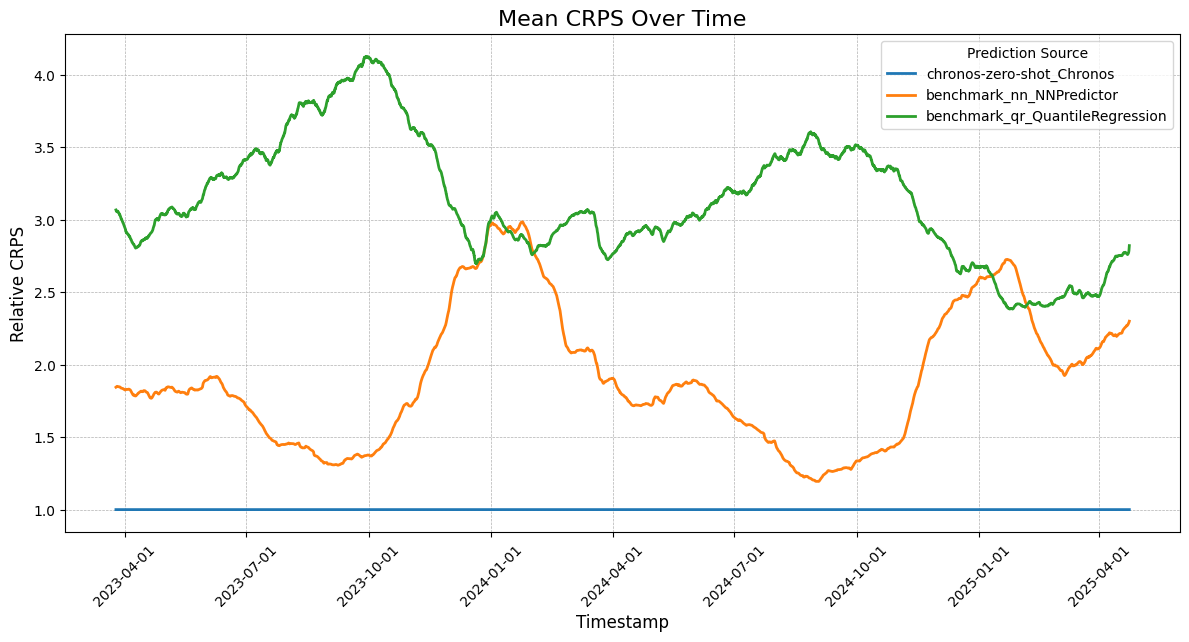

In [17]:
selected_keys = [
    "benchmark_qr_QuantileRegression",
    "benchmark_nn_NNPredictor",
    "chronos-zero-shot_Chronos",
]

plot_crps(results, selected_keys=selected_keys, rolling_window_eval=2000, reference_predictions="chronos-zero-shot_Chronos")

### Evaluation for individual model prediction (more details)

In [21]:
results["chronos-finetuned-full_PostprocessorMLE"].get_crps(mean_time=True, item_ids=[0])

,1,4,8,12,24,36,48,60
mean,505.67,769.68,935.01,1036.36,1170.78,1313.73,1352.68,1440.61


In [23]:
results["chronos-finetuned-full_PostprocessorMLE"].get_quantile_scores()

,1,4,8,12,24,36,48,60,QS averaged over all lead times
quantile,,,,,,,,,
0.1,236.27,551.25,785.59,913.67,1102.88,1198.73,1220.12,1255.64,908.02
0.2,373.36,842.55,1199.04,1397.99,1671.96,1859.92,1895.14,1946.86,1398.35
0.3,461.53,1018.82,1457.80,1706.04,2028.16,2268.94,2311.91,2378.13,1703.92
0.4,510.89,1111.51,1595.78,1872.50,2218.10,2480.57,2523.66,2599.43,1864.05
0.5,526.96,1133.15,1627.78,1912.70,2258.16,2518.70,2561.44,2635.04,1896.74
0.6,510.67,1087.04,1560.84,1832.25,2153.62,2392.45,2430.01,2500.89,1808.47
0.7,460.20,972.10,1392.35,1630.56,1903.61,2101.97,2133.51,2200.09,1599.30
0.8,371.86,783.07,1113.62,1299.29,1498.34,1638.46,1671.76,1731.57,1263.49
0.9,234.69,495.68,698.78,806.18,916.87,1002.98,1027.83,1072.86,781.98


In [24]:
results["chronos-finetuned-full_PostprocessorMLE"].get_empirical_coverage_rates()

,1,4,8,12,24,36,48,60,Empirical coverage rates averaged over all lead times
quantile,,,,,,,,,
0.1,0.11,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10
0.2,0.21,0.19,0.19,0.19,0.18,0.19,0.18,0.18,0.19
0.3,0.31,0.28,0.28,0.28,0.28,0.27,0.27,0.27,0.28
0.4,0.41,0.38,0.38,0.38,0.38,0.37,0.37,0.37,0.38
0.5,0.51,0.48,0.49,0.48,0.48,0.48,0.47,0.47,0.48
0.6,0.61,0.59,0.59,0.59,0.59,0.59,0.59,0.59,0.59
0.7,0.70,0.70,0.70,0.70,0.71,0.70,0.70,0.71,0.70
0.8,0.80,0.81,0.81,0.81,0.82,0.82,0.83,0.83,0.82
0.9,0.90,0.91,0.91,0.92,0.93,0.94,0.94,0.94,0.92


<Figure size 800x800 with 0 Axes>

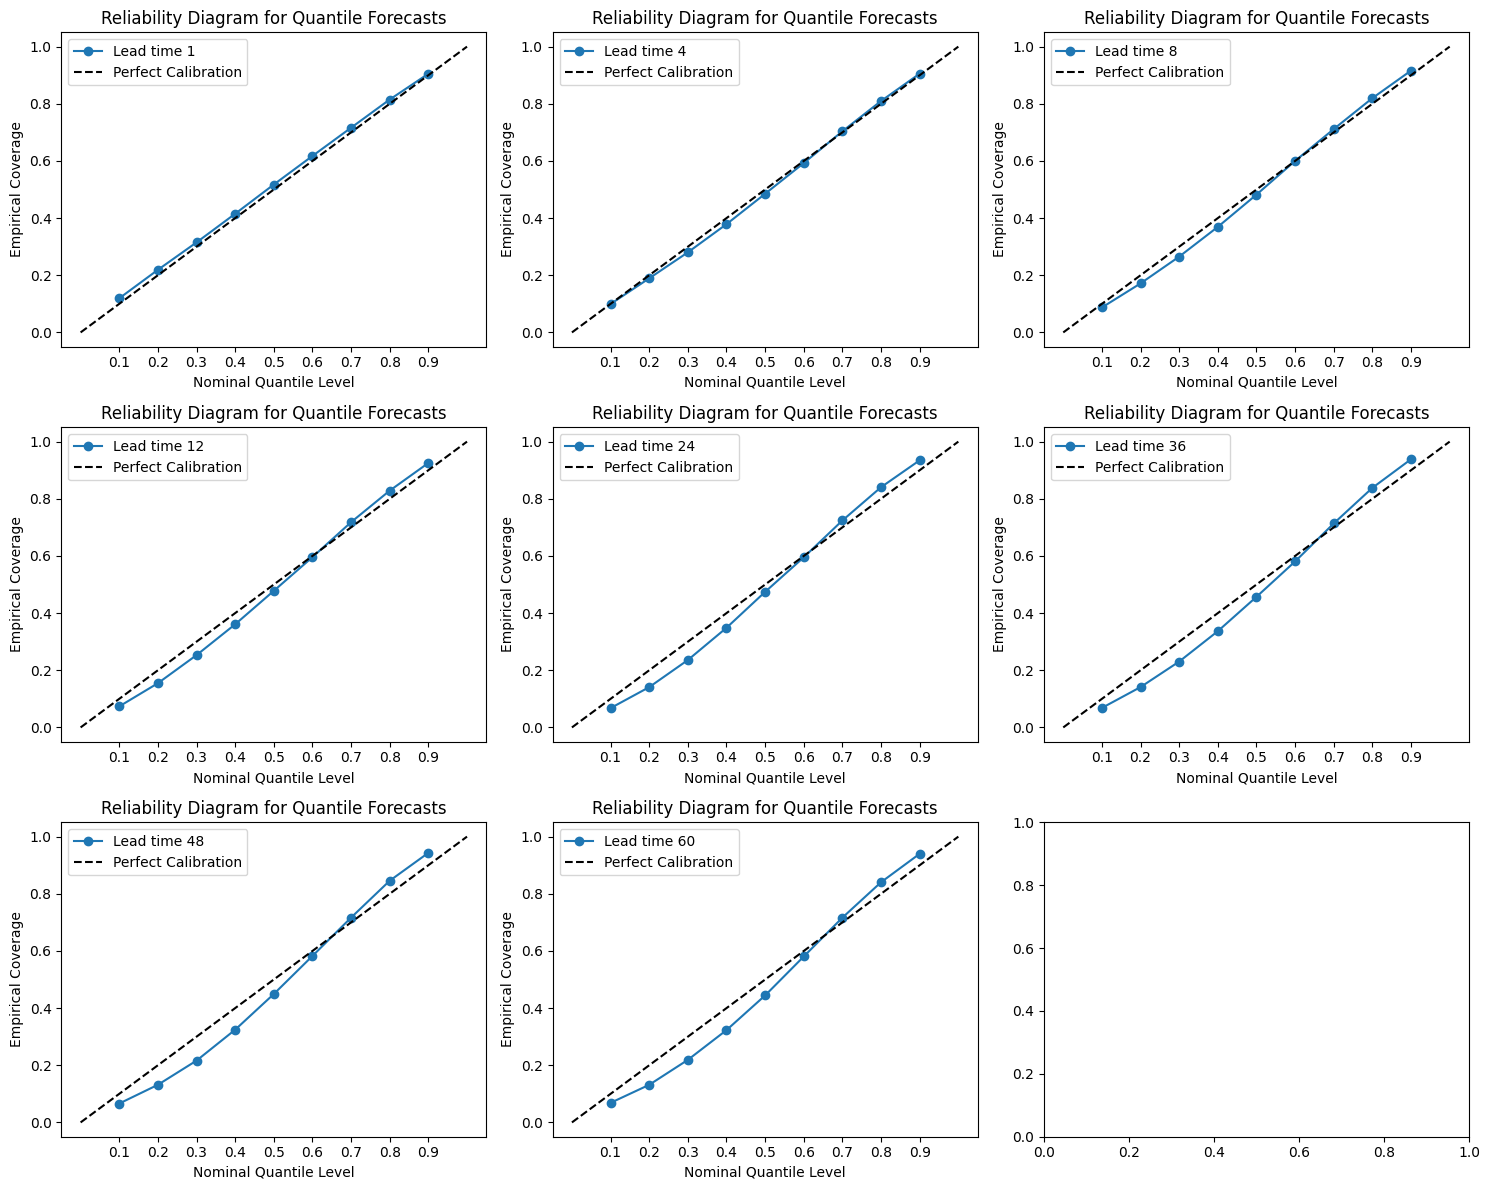

In [27]:
results["chronos-finetuned-full_PostprocessorMLE"].get_reliability_diagram(item_ids=[0], overlay=False)

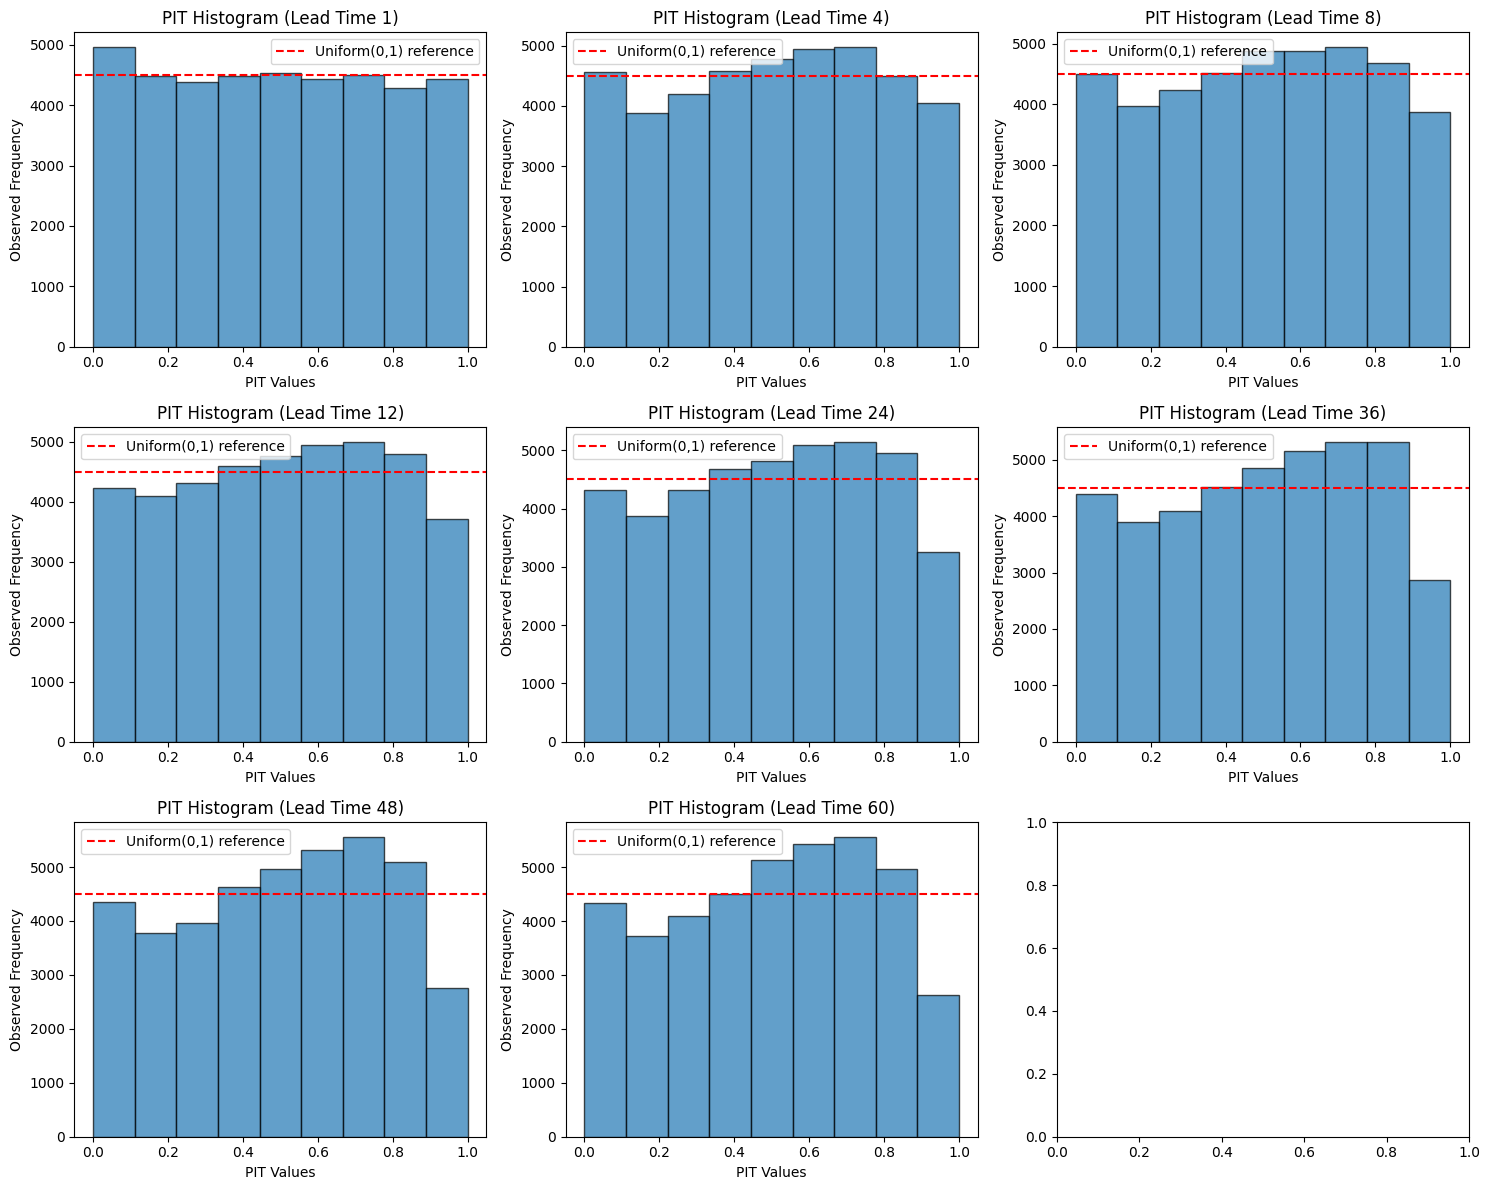

In [28]:
results["chronos-finetuned-full_PostprocessorMLE"].get_pit_histogram()

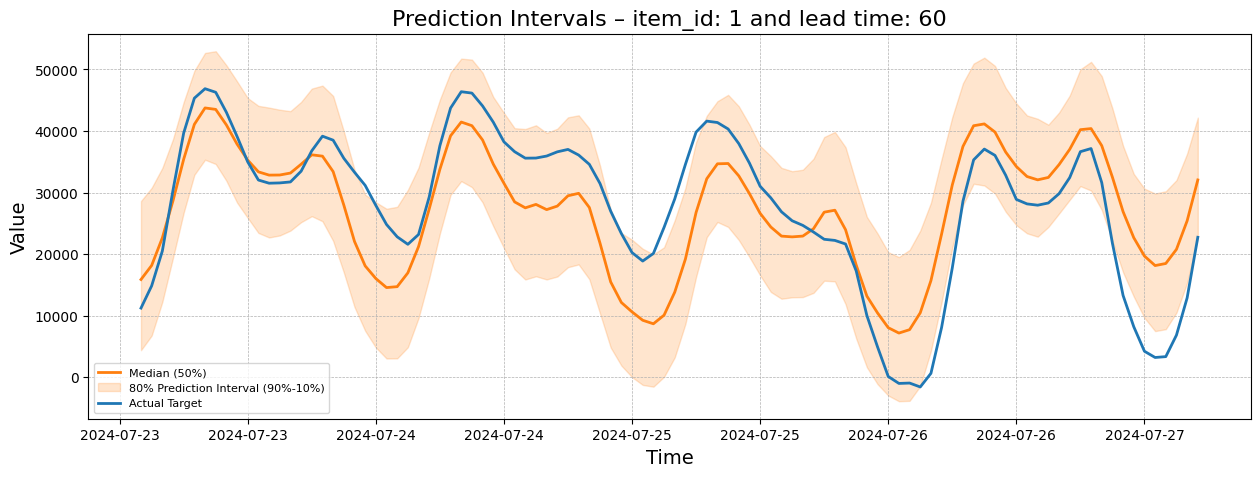

In [ ]:
# get random plots, in this case for 60 hours ahead predictions
results["chronos-finetuned-full_PostprocessorMLE"].results[60].get_random_plot(item_id=1)

# Additional Experiments

#### Compare chronos zero shot performance before and after 01-01-2023 against nn benchmark (Energy consumption)
- data used for training chronos goes until 2022. It might be that the gap between benchmark predictions and zero-shot chronos predictions increases after that.

In [ ]:
# create TimesSeriesDataFrame for convenience
data = TimeSeriesDataFrame(df)
data_train, data_test = data.split_by_time(pd.Timestamp("01-01-2020"))

lead_times = [1,4,8,12,24,36,48,60] # could also specify different ones
freq = pd.Timedelta("1h")

chronos = Chronos(model_name="amazon/chronos-bolt-tiny",
                  device_map="mps",
                  lead_times=lead_times,
                  freq=freq,
                  )

# get zero shot perdictions on test dataset
predictions_raw = chronos.predict(data=data_test,
                                  previous_context_data=data_train)

nn_predictor = NNPredictor(quantiles = np.arange(0.1, 1, 0.1),
                           lead_times=lead_times,
                           freq=freq)

nn_predictor.fit(data_train)
predictions_benchmark_nn = nn_predictor.predict(data_test)

all_predictions = {"chronos_predictions_raw": predictions_raw, "predictions_benchmark_nn": predictions_benchmark_nn}

Load chronos pipeline.


100%|██████████| 93108/93108 [00:19<00:00, 4886.58it/s]


In [ ]:
get_crps_by_period(all_predictions, 
                   lead_times=None, 
                   item_ids=None, 
                   reference_predictions="predictions_benchmark_nn",
                   date_splits=[ pd.Timestamp("01-01-2023")])

,chronos_predictions_raw,predictions_benchmark_nn
2020-01-01 00:00:00_to_2023-01-01 00:00:00,0.632009,1.0
2023-01-01 00:00:00_to_2025-04-23 23:00:00,0.629481,1.0


#### Evaluation results on Exchange rate data

Zero-shot evaluation results of chronos-bolt may appear overly optimistic because the evaluation datasets might not represent true out-of-sample conditions.

- Explanation: Forecast accuracy might be inflated due to the evaluation method. Each time series is evaluated using only the last H observations, ignoring differences in time periods across datasets (e.g., ERCOT Load 2004-2021, London Smart Meters 2011-2014).
- Dataset for illustration: Exchange rate data

In [ ]:
# import gzip
# from io import StringIO

# # Open and read the file
# with gzip.open('/Users/louisskowronek/Downloads/exchange_rate.txt.gz', 'rt') as f:  # 'rt' means read text mode
#     content = f.read()
# df = pd.read_csv(StringIO(content), header=None)
# # data used in chronos paper goes until 2019-01-31

In [ ]:
# 0: US/AUD https://fred.stlouisfed.org/series/DEXUSAL 
# 1: US/UK  https://fred.stlouisfed.org/series/DEXUSUK
# 2: US/CA  https://fred.stlouisfed.org/series/DEXCAUS (flipped)
# 3: US/SZ  https://fred.stlouisfed.org/series/DEXSZUS (flipped)
# 4: US/CH  https://fred.stlouisfed.org/series/DEXCHUS (flipped)
# 5: US/JP  https://fred.stlouisfed.org/series/DEXJPUS (flipped)
# 6: US/NZ  https://fred.stlouisfed.org/series/DEXUSNZ 
# 7: US/SI  https://fred.stlouisfed.org/series/DEXSIUS (flipped)

In [ ]:
# prepare data
ex_rates = {}
for f in Path("data/exchange_rates/").iterdir():
    file = pd.read_csv(f)
    file["observation_date"] = pd.to_datetime(file["observation_date"])
    file = file.rename(columns={"observation_date":"timestamp"})
    file.set_index("timestamp", inplace=True)
    symbol = f.name.removesuffix(".csv").removeprefix("DEX")

    if symbol.endswith("US"):
        file = 1/file
        symbol = symbol[2:] + symbol[:2]

    file.columns = [symbol]
    ex_rates[symbol] = file

df_ex_rates = pd.concat(ex_rates.values(), axis=1)
df_ex_rates = df_ex_rates.reset_index()
df_ex_rates = df_ex_rates.melt(id_vars="timestamp", var_name="item_id", value_name="target")

df_ex_rates["item_id"], mapping = pd.factorize(df_ex_rates["item_id"])
mapping = {i: m for i, m in zip(range(0, len(mapping)), mapping)}

In [ ]:
data = TimeSeriesDataFrame(df_ex_rates)
freq = pd.tseries.offsets.BusinessDay(1)
lead_times = [1,4,8,12,24,36,48,60]

In [ ]:
# chronos zero shot results
pipeline = ForecastingPipeline(model=Chronos, 
                               model_kwargs={"pretrained_model_name_or_path": "amazon/chronos-bolt-tiny", "device_map": "mps", "lead_times": lead_times, "freq": freq}, 
                               # postprocessors=[PostprocessorMLE, PostprocessorQR, PostprocessorEQC],
                               output_dir=Path("./results/pipeline/exchange_rates/chronos-zero-shot"))

data_train, data_val, data_test = pipeline.split_data(data=TimeSeriesDataFrame(data), 
                                                      test_start_date=pd.Timestamp("2017-01-01"), 
                                                      train_window_size=None,
                                                      test_window_size=None,
                                                      val_window_size=None)

#predictions_poos = pipeline.predict(data_test=data_val, data_previous_context=data_train)
predictions_chronos = pipeline.predict(data_test=data_test, data_previous_context=data_train)

2025-05-03 13:07:39,070 - INFO - chronos.py - Loading Chronos pipeline from model: amazon/chronos-bolt-tiny
2025-05-03 13:07:39,070 - INFO - chronos.py - Initializing Chronos pipeline with model: amazon/chronos-bolt-tiny
2025-05-03 13:07:40,047 - INFO - pipeline.py - Starting data split operation.
2025-05-03 13:07:40,049 - INFO - pipeline.py - Data split operation completed successfully.
2025-05-03 13:07:40,050 - INFO - pipeline.py - Starting prediction for test data from 2017-01-02 00:00:00 to 2025-04-25 00:00:00
2025-05-03 13:07:40,050 - INFO - pipeline.py - Running prediction using the model: Chronos
Predicting: 100%|██████████| 2109/2109 [00:25<00:00, 81.49it/s]
2025-05-03 13:08:06,064 - INFO - pipeline.py - Prediction completed successfully.
2025-05-03 13:08:06,065 - INFO - pipeline.py - Prediction completed in 26.015036 seconds.


In [ ]:
# Nearest neighbour predictor
pipeline = ForecastingPipeline(model=NNPredictor, 
                               model_kwargs={"quantiles": quantiles, "lead_times": lead_times, "freq": freq}, 
                               # postprocessors=[PostprocessorQR, PostprocessorMLE],
                               output_dir=Path("./results/pipeline/exchange_rates/benchmark_nn"))

predictions_nn = pipeline.predict(data_test=data_test, data_previous_context=data_train)


2025-05-03 13:08:07,083 - INFO - pipeline.py - Starting prediction for test data from 2017-01-02 00:00:00 to 2025-04-25 00:00:00
2025-05-03 13:08:07,083 - INFO - pipeline.py - Running prediction using the model: NNPredictor
2025-05-03 13:08:07,084 - INFO - nearest_neighbour.py - Building history from provided context_data.
100%|██████████| 17360/17360 [00:04<00:00, 4299.19it/s]
2025-05-03 13:08:11,239 - INFO - pipeline.py - Prediction completed successfully.
2025-05-03 13:08:11,239 - INFO - pipeline.py - Prediction completed in 4.15632 seconds.


In [ ]:
predictions_chronos.update(predictions_nn)

In [ ]:
get_crps_scores(predictions_chronos)

,Chronos,NNPredictor
lead times,,
1,0.003,0.009
4,0.004,0.009
8,0.006,0.010
12,0.007,0.011
24,0.010,0.013
36,0.012,0.015
48,0.013,0.016
60,0.015,0.017


In [ ]:
get_crps_by_period(predictions_chronos,
                   lead_times=None, 
                   item_ids=None, 
                   reference_predictions="NNPredictor",
                   date_splits=[pd.Timestamp("01-01-2018"),
                                pd.Timestamp("01-01-2019"),
                                pd.Timestamp("01-01-2020"),
                                pd.Timestamp("01-01-2021"),
                                pd.Timestamp("01-01-2022"),
                                pd.Timestamp("01-01-2023"),
                                pd.Timestamp("01-01-2024"), 
                                pd.Timestamp("01-01-2025")])

,Chronos,NNPredictor
02-01-2017_to_01-01-2018,0.870,1.0
01-01-2018_to_01-01-2019,0.794,1.0
01-01-2019_to_01-01-2020,0.871,1.0
01-01-2020_to_01-01-2021,0.732,1.0
01-01-2021_to_01-01-2022,0.916,1.0
01-01-2022_to_01-01-2023,0.750,1.0
01-01-2023_to_01-01-2024,0.850,1.0
01-01-2024_to_01-01-2025,0.758,1.0
01-01-2025_to_25-04-2025,0.787,1.0


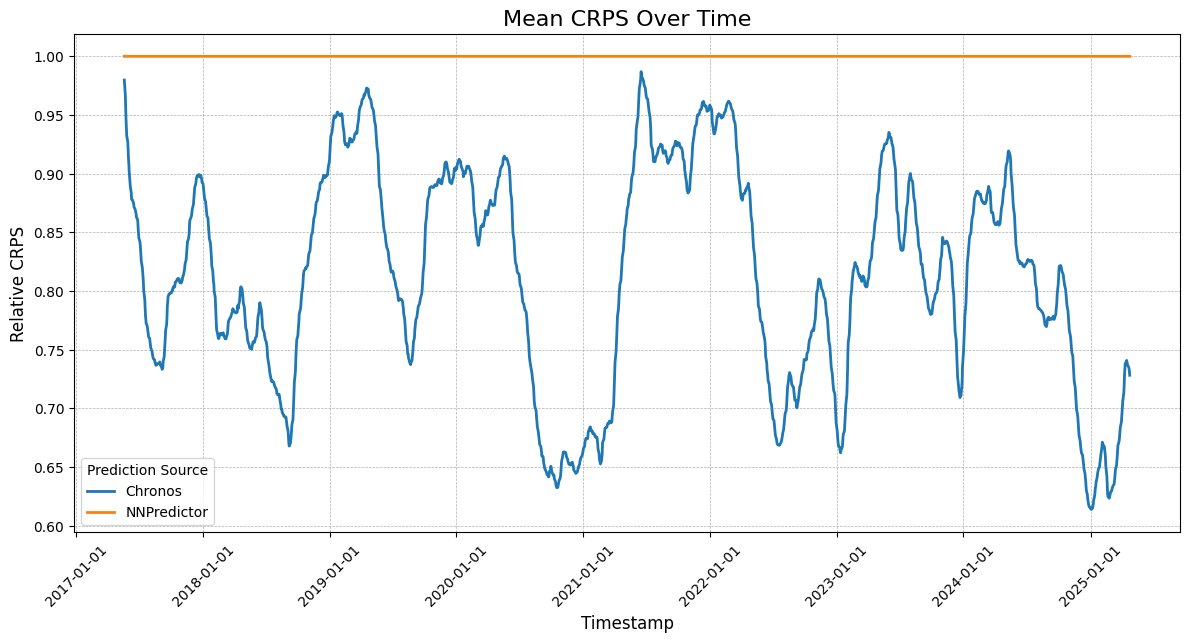

In [ ]:
plot_crps(predictions_chronos, rolling_window_eval=100, reference_predictions="NNPredictor")

regress crps difference on dummy variable which moves from 0 to 1 in 2023

In [ ]:
import statsmodels.api as sm

In [ ]:
crps_diff =  predictions_chronos["NNPredictor"].get_crps(mean_lead_times=True) - predictions_chronos["Chronos"].get_crps(mean_lead_times=True)

In [ ]:
crps_diff_item = crps_diff.groupby("timestamp").mean()
crps_diff_item = crps_diff_item.dropna()

In [ ]:
crps_diff_item["dummy"] = 0
crps_diff_item.loc[crps_diff_item.index.get_level_values("timestamp") > pd.Timestamp("01-01-2023"), "dummy"] = 1
x = crps_diff_item["dummy"]
x = sm.add_constant(x)
y = crps_diff_item["Mean CRPS"].values
model = sm.OLS(endog=y, exog=x).fit(cov_type='HC3')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3545
Date:                Sat, 03 May 2025   Prob (F-statistic):              0.552
Time:                        14:50:57   Log-Likelihood:                 8658.1
No. Observations:                2169   AIC:                        -1.731e+04
Df Residuals:                    2167   BIC:                        -1.730e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.000     33.536      0.0

<Axes: xlabel='timestamp'>

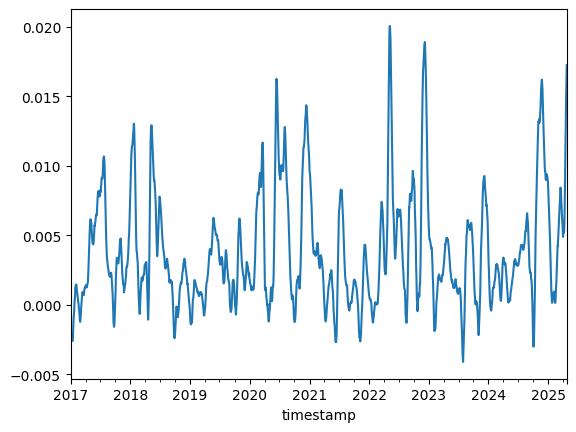

In [ ]:
crps_diff_item["Mean CRPS"].rolling(window=10).mean().plot()